# Proyecto 1
### Explorando los Algoritmos de Aprendizaje Supervisado

Estudiantes: 

Carlos Adrián Araya Ramírez---------2018319701

Michael Shakime Richards Sparks----2018170667

In [410]:


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.calibration import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score

from ourmodels.KNearestNeighbors import KNearestNeighbors as OurKNearestNeighbors
from ourmodels.DecisionTree import DecisionTreeClassifier as OurDecisionTree
from ourmodels.LogisticRegression import LogisticRegression as OurLogisticRegression



# 1. ANÁLISIS DE DATOS

In [411]:
# Load the architecture 1 notes dataset
df = pd.read_csv("datasets/DataSetGrades/notas_arqui1.csv")
df

,Proyecto 1,Proyecto 2,Examen 1,Tarea 1,Final
0,100.0,100.0,53.3,76.0,80
1,0.0,0.0,12.6,0.0,5
2,100.0,45.0,49.6,100.0,80
3,0.0,0.0,0.0,0.0,0
4,100.0,100.0,61.6,66.7,80
...,...,...,...,...,...
100,59.3,100.0,61.0,70.0,85
101,66.3,100.0,100.0,88.3,85
102,54.4,100.0,100.0,100.0,85
103,72.0,100.0,100.0,100.0,85


In [412]:
df.describe()

,Proyecto 1,Proyecto 2,Examen 1,Tarea 1,Final
count,105.000000,105.000000,105.000000,105.00000,105.000000
mean,56.700952,61.665714,47.039048,48.18000,64.285714
std,30.273584,33.452805,28.839181,35.41112,28.168693
min,0.000000,0.000000,0.000000,0.00000,0.000000
25%,38.000000,53.400000,28.800000,14.70000,60.000000
50%,56.100000,65.000000,42.200000,48.00000,75.000000
75%,82.000000,95.000000,66.300000,76.00000,80.000000
max,100.000000,100.000000,100.000000,100.00000,100.000000


In [413]:
# Replace Final grades with 0 or 1
# 0 = No pasa el curso
# 1 = Pasa el curso

df['Final'] = df['Final'].apply(lambda x: 1 if x > 67.5 else 0)
df.head(25)

,Proyecto 1,Proyecto 2,Examen 1,Tarea 1,Final
0,100.0,100.0,53.3,76.0,1
1,0.0,0.0,12.6,0.0,0
2,100.0,45.0,49.6,100.0,1
3,0.0,0.0,0.0,0.0,0
4,100.0,100.0,61.6,66.7,1
5,42.5,60.0,55.1,24.0,1
6,45.3,60.0,38.5,48.0,1
7,100.0,60.0,57.0,0.0,1
8,80.0,100.0,52.4,66.7,1
9,79.3,62.0,40.3,48.0,1


<AxesSubplot:>

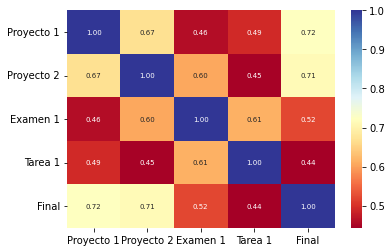

In [414]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Visualize the correlation matrix as a heatmap
sns.heatmap(corr_matrix, annot=True, cmap='RdYlBu', annot_kws={"fontsize": 7},  fmt='.2f')

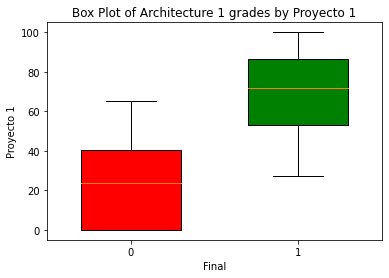

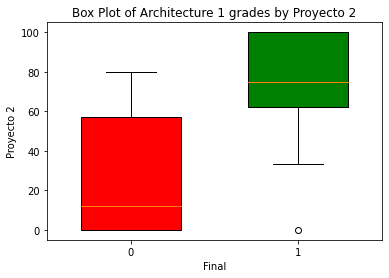

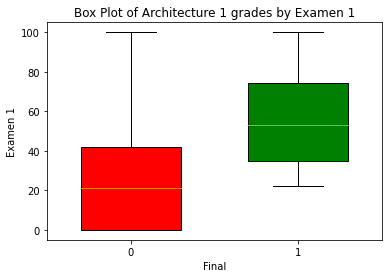

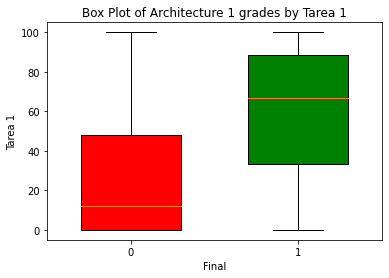

In [415]:
# Selected features (Proyecto 1, Proyecto 2, Examen 1, Tarea 1)
features = df.columns[:-1]

# Define colors for each Final value
colors = {0: 'red', 1: 'green'}

# Create a box plot for each feature
for feature in features:
    # Create a new figure and axis for each feature
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # Loop through each quality value and plot the box
    for final_score in sorted(df['Final'].unique()):
        box_color = colors[final_score]  # Get the color for this quality value
        data = df[df['Final'] == final_score][feature]  # Get the data for this quality value
        ax.boxplot(data, positions=[final_score], widths=0.6, showfliers=True, patch_artist=True, boxprops=dict(facecolor=box_color))
    
    # Set the title and axis labels
    plt.title("Box Plot of Architecture 1 grades by " + feature)
    plt.xlabel("Final")
    plt.ylabel(feature)
    
    # Set the x-axis limits and ticks
    ax.set_xlim(-0.5, 1.5)
    ax.set_xticks(range(0, 2))
    ax.set_xticklabels(range(0, 2))
    
    # Remove the grid lines
    ax.grid(False)
    
    # Show the plot
    plt.show()

# 2. FEATURE ENGINEERING

In [416]:
""" Remove outliers, this values skew the mean and standard deviation, resulting in normalization that is not representative of the majority of the data points. """

# Get the interquartile range for each column
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Get the lower and upper bounds for each column
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

# Replace the values that are outside the interquartile range with the respective bound
df_iqr = df.clip(lower=lower, upper=upper, axis=1)

# Remove the values that are outside the interquartile range
# df_iqr = df[(df >= lower) & (df <= upper)].dropna()

""" Normalize using MinMaxScaler method. """

# Create a copy of the dataframe without the quality feature
df_to_normalize = df_iqr.iloc[:, :-1]

# Initialize the MinMaxScaler object
scaler = MinMaxScaler()

# Fit the scaler to the df_to_normalize dataset
scaler.fit(df_to_normalize)

# Transform the df_without_quality dataset using the scaler
df_normalized = pd.DataFrame(scaler.transform(df_to_normalize), columns=df_to_normalize.columns)

# Add the quality feature of the original dataframe to the normalized dataframe
df_normalized['Final'] = df['Final']

df_normalized

,Proyecto 1,Proyecto 2,Examen 1,Tarea 1,Final
0,1.000,1.00,0.533,0.760,1
1,0.000,0.00,0.126,0.000,0
2,1.000,0.45,0.496,1.000,1
3,0.000,0.00,0.000,0.000,0
4,1.000,1.00,0.616,0.667,1
...,...,...,...,...,...
100,0.593,1.00,0.610,0.700,1
101,0.663,1.00,1.000,0.883,1
102,0.544,1.00,1.000,1.000,1
103,0.720,1.00,1.000,1.000,1


# 3. PREPROCESAMIENTO

In [417]:
# Divides the "Final" column into two categories using bins and labels.
bins = [-1, 0.5, 1]
labels = ["REPROBADO", "APROBADO"]
df_normalized["Final"] = pd.cut(df_normalized["Final"], bins=bins, labels=labels)

# show the updated dataframe
count = df_normalized["Final"].value_counts()
print(f"Categorías:\n   APROBADO {count[0]}\n   REPROBADO {count[1]}\n")

# Converting the categorical labels in the "Final" column of the normalized dataset to numerical values.
lb = LabelEncoder()
df_normalized["Final"] = lb.fit_transform(df_normalized["Final"])

# Replace the labels with 0 and 1
df_normalized["Final"].replace({1: 0, 0: 1}, inplace=True)

# Get the arrays
X = df_normalized.drop("Final", axis=1)
y = df_normalized["Final"]

# Cast to numpy
X = X.to_numpy()
y = y.to_numpy()

# Splits the dataset into training and testing sets using train_test_split (stratifying based on the "Final" variable)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.36, stratify=y)

Categorías:
   APROBADO 73
   REPROBADO 32




# MODELOS
Evaluar de manera objetiva 3 algoritmos de aprendizaje supervisado

In [418]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve

def compare_models_metrics(y_test, y_pred_sklearn, y_pred_our_model, sklearn_model):
    
    '''SKLEARN'''
    # Calculate sklearn accuracy, precision and recall
    sklearn_accuracy = accuracy_score(y_test, y_pred_sklearn)
    sklearn_precision = precision_score(y_test, y_pred_sklearn)
    sklearn_recall = recall_score(y_test, y_pred_sklearn)
    sklearn_auc = roc_auc_score(y_test, y_pred_sklearn)

    '''OUR MODEL'''
    # Calculate our model metrics
    our_accuracy = accuracy_score(y_test, y_pred_our_model)
    our_precision = precision_score(y_test, y_pred_our_model)
    our_recall = recall_score(y_test, y_pred_our_model)
    our_auc = roc_auc_score(y_test, y_pred_our_model)

    '''CHART'''
    # Get the probabilities of the positive class
    y_prob_sklearn = sklearn_model.predict_proba(X_test)[:, 1]
    # Calculate the TPR and FPR values for different classification thresholds
    fpr_sklearn, tpr_sklearn, thresholds_sklearn = roc_curve(y_test, y_prob_sklearn)
    # Plot the ROC curve
    plt.plot(fpr_sklearn, tpr_sklearn, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % sklearn_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('Especifidad')
    plt.ylabel('Sensibilidad')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()

    '''TABLE'''
    # Create a dataframe with the metrics
    metrics = {
        'Accuracy': [sklearn_accuracy, our_accuracy,],
        'Precision': [ sklearn_precision, our_precision,],
        'Recall': [sklearn_recall, our_recall, ],
        'AUC': [sklearn_auc, our_auc, ]
    }
        
    return pd.DataFrame.from_dict(metrics, orient='index', columns=["Sklearn's model", 'Our model', ])

### REGRESIÓN LOGÍSTICA

Best parameters:  {'C': 4.7}
Best score:  0.8967032967032967


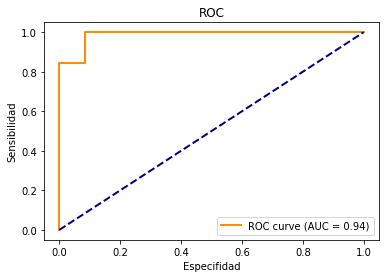

,Sklearn's model,Our model
Accuracy,0.947368,0.894737
Precision,0.961538,0.958333
Recall,0.961538,0.884615
AUC,0.939103,0.900641


In [419]:
""" Find best params for the model using GridSearch """

# Define the hyperparameters to tune
param_grid = {'C': [0.8, 4.7, 4.8, 4.9, 5]}
max_iter = 100000

# Create an instance of the logistic regression model
log_reg = LogisticRegression(max_iter=max_iter)

# Create and fit GridSearchCV object to search for the best hyperparameters
grid_search = GridSearchCV(log_reg, param_grid, cv=5).fit(X_train, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# print the best parameters and the corresponding accuracy score
print("Best parameters: ", best_params)
print("Best score: ", best_score)

""" Use best params the create the models """

'''SKLEARN'''
# Create a new logistic regression model with the best parameters and make predictions
sklearn_log_reg = LogisticRegression(C=best_params['C'])
sklearn_log_reg.fit(X_train, y_train)
y_pred_sklearn = sklearn_log_reg.predict(X_test)

'''OUR MODEL'''
# Fit Our model and make predictions
our_log_reg = OurLogisticRegression(lr=best_params['C'], num_iter=max_iter)
our_log_reg.fit(X_train, y_train)
y_pred_our_model = our_log_reg.predict(X_test, 0.5)

# Show Graphics and table
dataframe = compare_models_metrics(y_test, y_pred_sklearn, y_pred_our_model, sklearn_log_reg)
dataframe

# KNN

Best parameters:  {'n_neighbors': 13, 'weights': 'distance'}
Best score:  0.8967032967032967


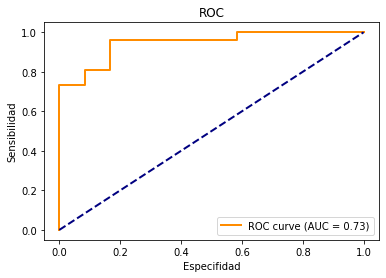

,Sklearn's model,Our model
Accuracy,0.815789,0.763158
Precision,0.806452,0.774194
Recall,0.961538,0.923077
AUC,0.730769,0.669872


In [420]:
""" Find best params for the model using GridSearch """

# Define the parameter grid for grid search
n = [i for i in range(1, 30, 2)]
param_grid = {'n_neighbors': n, 'weights': ['uniform', 'distance']}

# Create a KNeighborsClassifier instance
knn = KNeighborsClassifier()

# Create and fit a GridSearchCV instance
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, n_jobs=-1).fit(X_train, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and the corresponding accuracy score
print("Best parameters: ", best_params)
print("Best score: ", best_score)

""" Use best params the create the models """

'''SKLEARN'''
# Create a new knn model with the best parameters and make predictions
sklearn_knn = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'], weights=best_params['weights'])
sklearn_knn.fit(X_train, y_train)
y_pred_sklearn = sklearn_knn.predict(X_test)

'''OUR MODEL'''
# Fit Our model and make predictions
our_tree = OurKNearestNeighbors(X_train, y_train, n_neighbors=best_params['n_neighbors'])
y_pred_our_model = our_tree.predict(X_test)

# Show Graphics and table
dataframe = compare_models_metrics(y_test, y_pred_sklearn, y_pred_our_model, sklearn_knn)
dataframe